In [188]:
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
from spacy.lang.en import English
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV

RS=1

# Preprocessing

Использую модель `en_core_web_sm` из `spacy` для препроцессинга (лемматизация, стоп-слова и пунктуация)

In [45]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
nlp.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

В датасете есть некоторые документы с малым кол-вом категорий(ошибка на этапе сбора), их нужно исключить

In [104]:
from collections import defaultdict
from sklearn.model_selection import train_test_split

with open("dataset/combined.json", "r") as f:
    dataset = json.load(f)
catalog = dataset["catalog"]

cats = defaultdict(int)
for doc in catalog:
    cats[doc["catergory"]] += 1
catalog = [doc for doc in catalog if cats[doc["catergory"]] > 100]

x, y = [x["text"] for x in catalog], [x["catergory"] for x in catalog]

Векторизация занимает достаточно много времени, поэтому она вынесена в общий шаг

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1, 1),
    analyzer="word",
    # Доки spacy рекомендуют использовать nlp.pipe, но с помощью него менее удобно заменять tokenizer,
    # а разница в скорости небольшая, поэтому использую так
    tokenizer=lambda x: [
        i.lemma_.lower() for i in nlp(x) if not (i.is_stop or i.is_punct)
    ],
    token_pattern=None,
    min_df=0.01,
    max_df=0.9,
    lowercase=False,
    dtype=np.float32,
    smooth_idf=True,
    sublinear_tf=True,
    use_idf=True,
)

x_tr = tfidf.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_tr, y, random_state=RS, test_size=0.3)
len(tfidf.vocabulary_)

Посмотрим на процент документов, слова которых полностью содержаться в какой-либо категории.

Это позволит понять насколько просто моделям будет распознать различные категории по уникальному слову.

In [187]:
x_tr_inv = tfidf.inverse_transform(x_tr)
labels = list(set(y))
label_sets = defaultdict(set)
for doc, key in zip(x_tr_inv, y):
    label_sets[key].update(doc)

df = pd.DataFrame(columns=labels, index=labels, dtype=np.float32, data=[[0]*len(labels)]*len(labels))
for doc, key in zip(x_tr_inv, y):
    doc_s = set(doc)
    for k, s in label_sets.items():
        if len(doc_s.difference(s)) < 1:
            df.loc[key, k] += 1

for l in labels:
    df.loc[l] /= df.loc[l, l]
df *= 100
with pd.option_context('display.precision', 2):
    print(df)

               Politics  Entertainment  science    News  gaming
Politics         100.00          23.69     1.78   81.64    0.99
Entertainment     29.06         100.00    17.50   76.88   17.92
science            0.80           0.80   100.00    0.99    0.80
News              55.27          29.26    17.54  100.00    8.97
gaming             3.20           7.90    11.70   11.30  100.00


Из таблицы выше можно сделать вывод, что классифицировать категории `science` и `gaming` по уникальному слову будет достаточно просто, в то время как `Politics` и `Entertainment` имееют сильное пересечение с `News`

# Models

In [193]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

def metrics(clf):
    predicted = clf.predict(x_test)
    print(classification_report(y_test, predicted))
    ConfusionMatrixDisplay.from_predictions(y_test, predicted)
    plt.show()

Fitting 10 folds for each of 75 candidates, totalling 750 fits
{'alpha': 0.0006, 'loss': 'modified_huber', 'penalty': 'l2'}
               precision    recall  f1-score   support

Entertainment       0.94      0.95      0.95       275
         News       0.88      0.91      0.90       286
     Politics       0.93      0.91      0.92       308
       gaming       1.00      0.99      1.00       317
      science       1.00      0.99      1.00       308

     accuracy                           0.95      1494
    macro avg       0.95      0.95      0.95      1494
 weighted avg       0.95      0.95      0.95      1494



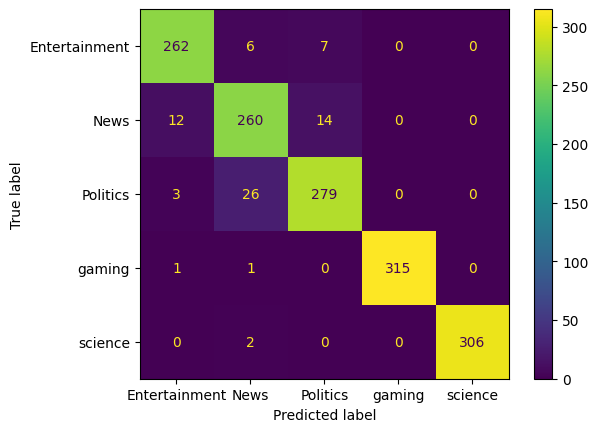

In [223]:
from sklearn.linear_model import SGDClassifier

text_clf_sgd = SGDClassifier(
    loss="hinge",
    penalty="l2",
    alpha=1e-4,
    random_state=RS,
    max_iter=5000,
    tol=1e-4,
    early_stopping=True,
    class_weight="balanced"
)

params = {
    "alpha": (6e-4, 5e-4, 4e-4, 1e-4, 5e-5),
    "penalty": ("l2", "elasticnet", "l1"),
    "loss": ("hinge", "perceptron", "squared_hinge", "log_loss", "modified_huber"),
}

gs_sgd = GridSearchCV(text_clf_sgd, params, refit=True, verbose=1, cv=10, n_jobs=-1)
gs_sgd.fit(x_train, y_train)
print(gs_sgd.best_params_)
metrics(gs_sgd.best_estimator_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'min_samples_split': 3, 'n_estimators': 500}
               precision    recall  f1-score   support

Entertainment       0.93      0.92      0.93       275
         News       0.85      0.85      0.85       286
     Politics       0.89      0.89      0.89       308
       gaming       0.98      0.98      0.98       317
      science       0.98      1.00      0.99       308

     accuracy                           0.93      1494
    macro avg       0.93      0.93      0.93      1494
 weighted avg       0.93      0.93      0.93      1494



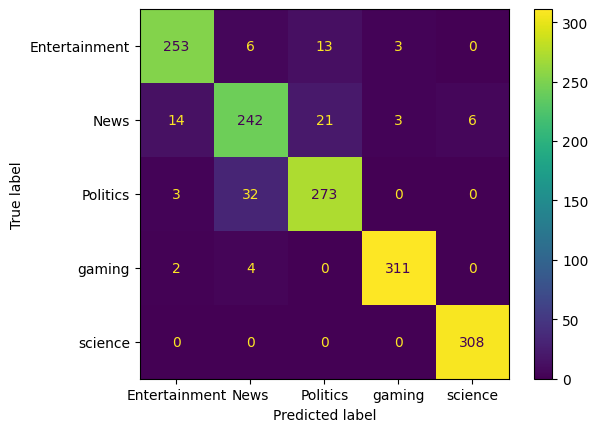

In [220]:
from sklearn.ensemble import RandomForestClassifier

text_clf_rfc = RandomForestClassifier(random_state=RS, criterion="gini")

params = {
    "min_samples_split": (2, 3, 4, 5),
    "n_estimators": (200, 300, 500),
}

gs_rfc = GridSearchCV(text_clf_rfc, params, refit=True, verbose=1, cv=3, n_jobs=-1)
gs_rfc.fit(x_train, y_train)
print(gs_rfc.best_params_)
metrics(gs_rfc.best_estimator_)

С KNN что-то не так, может неправильно использую?

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
               precision    recall  f1-score   support

Entertainment       1.00      0.01      0.01       275
         News       0.56      0.06      0.11       286
     Politics       1.00      0.01      0.02       308
       gaming       1.00      0.00      0.01       317
      science       0.21      1.00      0.35       308

     accuracy                           0.22      1494
    macro avg       0.75      0.22      0.10      1494
 weighted avg       0.75      0.22      0.10      1494



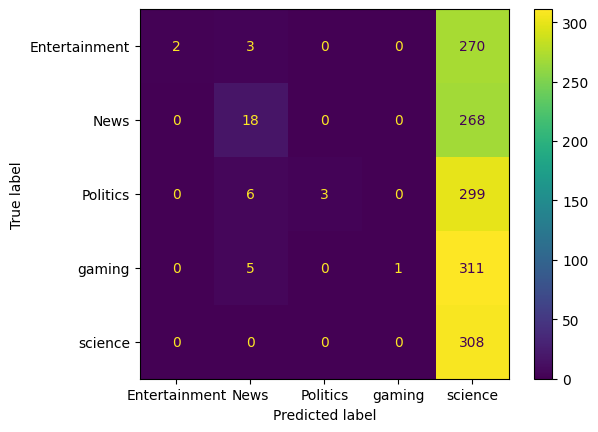

In [215]:
from sklearn.neighbors import KNeighborsClassifier

text_clf_knn = KNeighborsClassifier(n_jobs=-1)

params = {
    "n_neighbors": (3, 5, 10),
    "weights": ("uniform", "distance"),
    "p": (1, 2)
}

gs_knn = GridSearchCV(text_clf_knn, params, refit=True, verbose=1, cv=3)
gs_knn.fit(x_train, y_train)
print(gs_knn.best_params_)
metrics(gs_knn.best_estimator_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'C': 0.68, 'loss': 'squared_hinge'}
               precision    recall  f1-score   support

Entertainment       0.95      0.95      0.95       275
         News       0.89      0.91      0.90       286
     Politics       0.93      0.92      0.92       308
       gaming       1.00      0.98      0.99       317
      science       1.00      1.00      1.00       308

     accuracy                           0.95      1494
    macro avg       0.95      0.95      0.95      1494
 weighted avg       0.95      0.95      0.95      1494



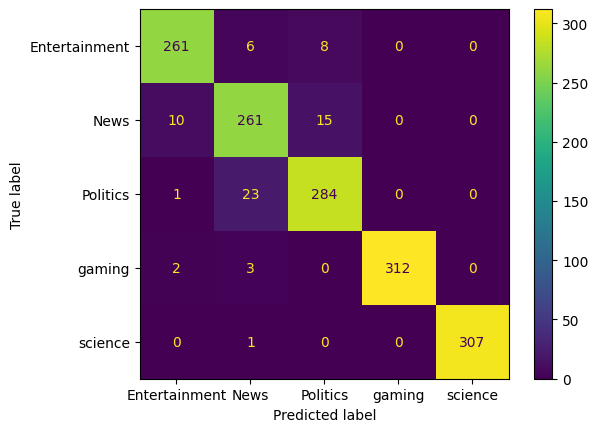

In [224]:
from sklearn.svm import LinearSVC

text_clf_svc = LinearSVC(class_weight="balanced", penalty="l2", random_state=RS)

params = {
    "loss": ("hinge", "squared_hinge"),
    "C": (0.65, 0.68, 0.7, 0.73, 0.8),
}

gs_svc = GridSearchCV(text_clf_svc, params, refit=True, verbose=1, cv=10, n_jobs=-1)
gs_svc.fit(x_train, y_train)
print(gs_svc.best_params_)
metrics(gs_svc.best_estimator_)

               precision    recall  f1-score   support

Entertainment       0.90      0.92      0.91       275
         News       0.85      0.80      0.83       286
     Politics       0.87      0.90      0.88       308
       gaming       0.99      0.97      0.98       317
      science       0.98      1.00      0.99       308

     accuracy                           0.92      1494
    macro avg       0.92      0.92      0.92      1494
 weighted avg       0.92      0.92      0.92      1494



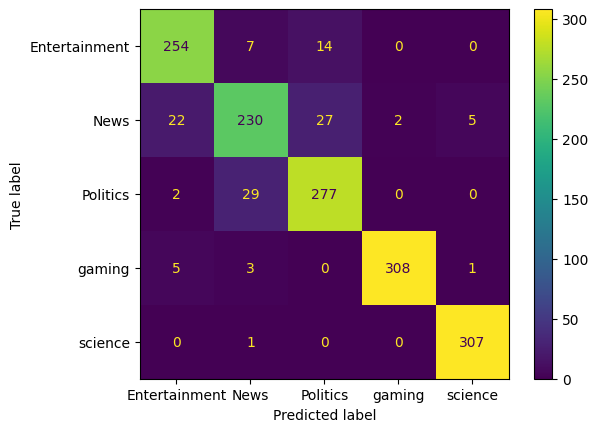

In [231]:
from sklearn.naive_bayes import MultinomialNB

text_clf_mnb = MultinomialNB()

text_clf_mnb.fit(x_train, y_train)
metrics(text_clf_mnb)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
{'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
               precision    recall  f1-score   support

Entertainment       0.68      0.73      0.70       275
         News       0.50      0.53      0.52       286
     Politics       0.67      0.65      0.66       308
       gaming       0.79      0.78      0.78       317
      science       0.89      0.83      0.86       308

     accuracy                           0.70      1494
    macro avg       0.71      0.70      0.70      1494
 weighted avg       0.71      0.70      0.71      1494



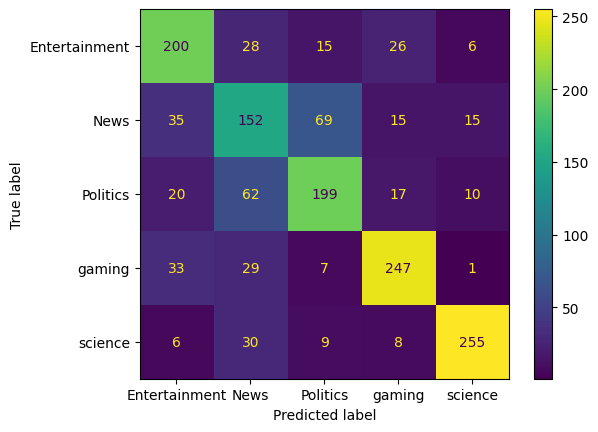

In [242]:
from sklearn.tree import DecisionTreeClassifier

text_clf_dtc = DecisionTreeClassifier(class_weight="balanced", random_state=RS)

params = {
    "splitter": ("best", "random"),
    "min_samples_split": (1, 2, 3, 5),
    "min_samples_leaf": (1, 2, 3),
    "splitter": ("best", "random"),
    "max_features": ("log2", "sqrt"),
}

gs_dtc = GridSearchCV(text_clf_dtc, params, refit=True, verbose=1, cv=10, n_jobs=-1)
gs_dtc.fit(x_train, y_train)
print(gs_dtc.best_params_)
metrics(gs_dtc.best_estimator_)

Итог: лучшие модели - SVM'ы (`LinearSVC` и `SGDClassifier`), за ними идёт `RandomForest`, после `MultinominalNB`, затем `DecisionTreeClassifier`.

Не уверен, что не так с `KNN`.

Как и предполагал, наибольшие проблемы были в отделении `Politics` от `News`, т.к. эти категории достаточно похожи.